# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

#### CRISP-DM-BANK.pdf => Page 2 => MATERIALS AND METHODS => Bank direct marketing data

The dataset collected is related to <b>17 campaigns that occurred between May 2008 and November 2010</b>, corresponding to a total of 79354 contacts. <br/>

During these phone campaigns, an attractive long-term deposit application, with good interest rates, was offered. <br/>

For each contact, a large number of attributes was stored (e.g. see <b>Table 2</b>) and if there was a success (the target variable). <br/>

For the whole database considered, there were 6499 successes (8% success rate)<br/>

<b>Table 2</b> Examples of some of the 59 client attributes<br/>
<b>Name Description and Values</b><br/>
<b>Personal Client Information</b><br/>
<b>Age</b> Age at the contact date (Numeric => 18)<br/>
<b>Marital</b> status Married, single, divorced, widowed, separated (Nominal)<br/>
Sex</b> Male or Female (Nominal)<br/>
<b>Bank Client Information</b><br/>
<b>Annual balance</b> in euro currency (Numeric)<br/>
<b>Debt card?</b> Yes or No (Nominal)<br/>
<b>Loans in delay?</b> Yes or No (Nominal)<br/>
<b>Last Contact Information</b><br/>
<b>Agent</b> Human that answered the call<br/>
<b>Date and time</b> Referring to when the contact was made<br/>
<b>Duration</b> Of the contact (in seconds)<br/>
<b>First Contact Information</b><br/>
<b>Agent</b> Human that answered the call<br/>
<b>Date and time</b> Referring to when the contact was made<br/>
<b>Duration</b> Of the contact (in seconds)<br/>
<b>Visualization's Information</b><br/>
Number of times the client has seen the product in the home banking site<br/>
<b>History Information</b><br/>
Result of the last campaign if another contact was made<br/>
Days since last contact in other campaign<br/>

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

##### Let's start by importing libraries and setting some configurations

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import SequentialFeatureSelector, RFE


import scipy.stats as stats
from scipy.stats import chi2_contingency

from pprint import pprint


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

##### Let's create a label encoder variable once that we can use through out the Notebook

In [2]:
le = LabelEncoder()

##### Let's create a dataframe and import the data file

In [3]:
bank_full_df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

##### Let's display the first 5 rows of the dataframe

In [4]:
bank_full_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



##### Let's generate descriptive statistics about the data

In [5]:
bank_full_df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


##### Let's get information about a DataFrame including the index dtype and columns, non-null values and memory usage

In [6]:
bank_full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

##### Let's get some information about missing values

In [7]:
bank_full_df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

##### Let's see if there are any duplicate records in the dataset

In [8]:
print("Number of duplicates : " + str(bank_full_df.duplicated().sum()))

Number of duplicates : 12


##### Let's drop the duplicate rows

In [9]:
bank_full_df = bank_full_df.drop_duplicates()
bank_full_df = bank_full_df.reset_index(drop=True)

##### Let's print unique values for each feature, the number of unique features

In [10]:
for col in bank_full_df.columns.tolist():
    pprint(f"++++++++++++++++++ {col} +++ {type(bank_full_df[col][0])} ++++++++++++++++++")
    pprint(f"{bank_full_df[col].unique()} : {bank_full_df[col].nunique()} : {bank_full_df[col].shape[0]}")
    print()

"++++++++++++++++++ age +++ <class 'numpy.int64'> ++++++++++++++++++"
('[56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44\n'
 ' 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67\n'
 ' 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91\n'
 ' 86 98 94 84 92 89] : 78 : 41176')

"++++++++++++++++++ job +++ <class 'str'> ++++++++++++++++++"
("['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'\n"
 " 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'\n"
 " 'student'] : 12 : 41176")

"++++++++++++++++++ marital +++ <class 'str'> ++++++++++++++++++"
"['married' 'single' 'divorced' 'unknown'] : 4 : 41176"

"++++++++++++++++++ education +++ <class 'str'> ++++++++++++++++++"
("['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'\n"
 " 'unknown' 'university.degree' 'illiterate'] : 8 : 41176")

"++++++++++++++++++ default +++ <class 'str'> ++++++++++++++++++"
"['no' 'unknown' 'yes'] 

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### I intend on focusing on features that are specific to the people who were contacted during the campaign.
##### The features I select will be

##### Let's draw histograms for the int64 features.
##### I found that the float64 features had too many values and didn't warrant any use for what I want to do with my project.

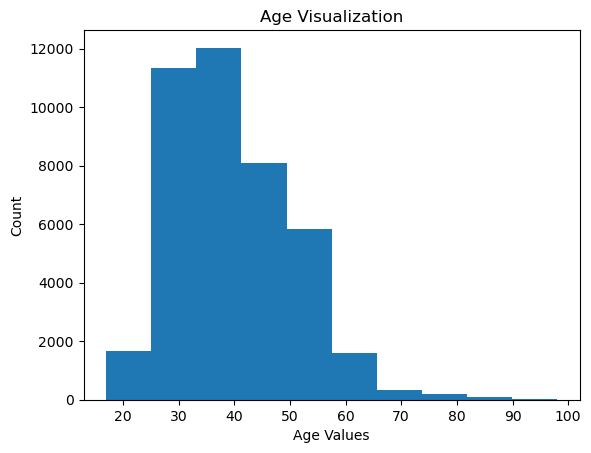

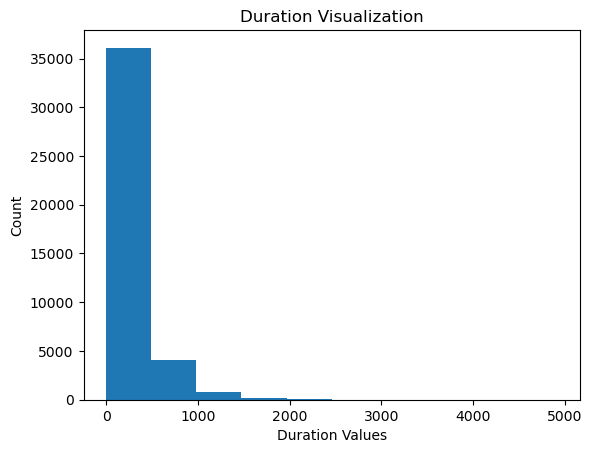

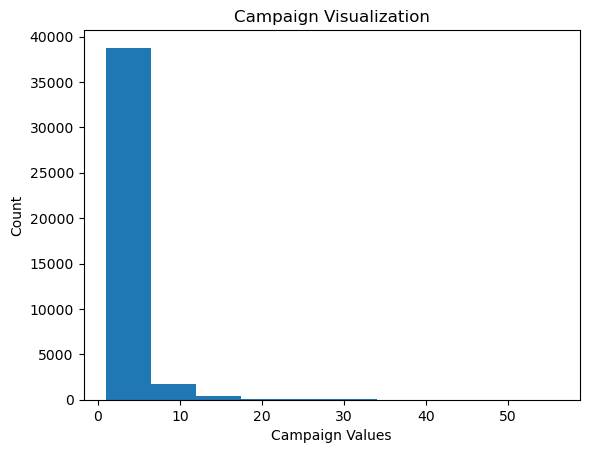

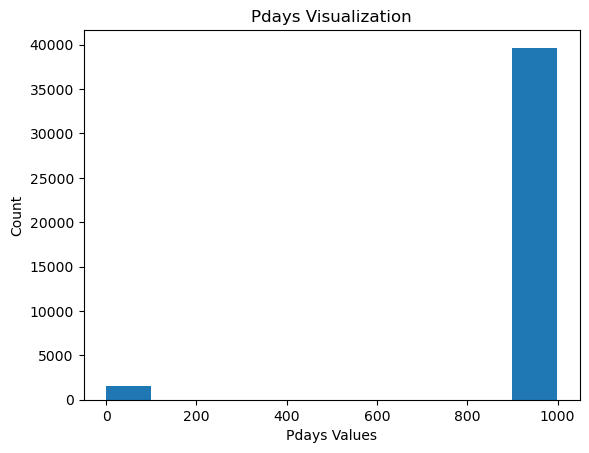

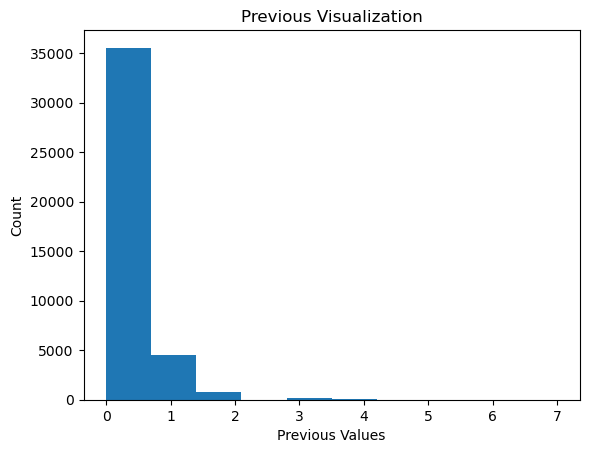

In [11]:
for col in bank_full_df.columns.tolist():
    match str(type(bank_full_df[col][0])):
        case "<class 'numpy.int64'>":
            plt.hist(bank_full_df[col])
            plt.title(col.capitalize() + ' Visualization')
            plt.xlabel(col.capitalize() + ' Values')
            plt.ylabel('Count')
            plt.show()
#        case "<class 'numpy.float64'>":
#            plt.hist(bank_full_df[col])
#            plt.title(col + ' Visualization')
#            plt.xlabel(col.capitalize() + ' Values')
#            plt.ylabel('Count')
#            plt.show()

##### The age feature appears to be skewered to the left.  I think this can be corrected by eliminating outliers.

##### Let's do a group by for the int64 features

In [12]:
for col in bank_full_df.columns.tolist():
    match str(type(bank_full_df[col][0])):
        case "<class 'numpy.int64'>":
            groupby_df = bank_full_df.groupby(["y",col]).agg({'y':['count']})
            print(groupby_df)
            print()
#        case "<class 'numpy.float64'>":
#            groupby = bank_full_df.groupby(col)[col].count()
#            print(groupby.sort_values(ascending=False))
#            print()

            y
        count
y   age      
no  17      3
    18     16
    19     22
    20     42
    21     73
    22    101
    23    178
    24    376
    25    505
    26    576
    27    736
    28    850
    29   1267
    30   1512
    31   1727
    32   1661
    33   1623
    34   1561
    35   1591
    36   1625
    37   1338
    38   1264
    39   1316
    40   1077
    41   1164
    42   1051
    43    967
    44    934
    45   1011
    46    951
    47    869
    48    882
    49    784
    50    788
    51    682
    52    698
    53    665
    54    620
    55    591
    56    624
    57    584
    58    518
    59    394
    60    225
    61     41
    62     37
    63     38
    64     30
    65     21
    66     28
    67     15
    68     18
    69     20
    70     28
    71     31
    72     21
    73     21
    74     17
    75     13
    76     16
    77      7
    78     13
    79      7
    80     13
    81     12
    82      6
    83      9
    84      4
    85

##### Let's draw pie charts for the int64 features

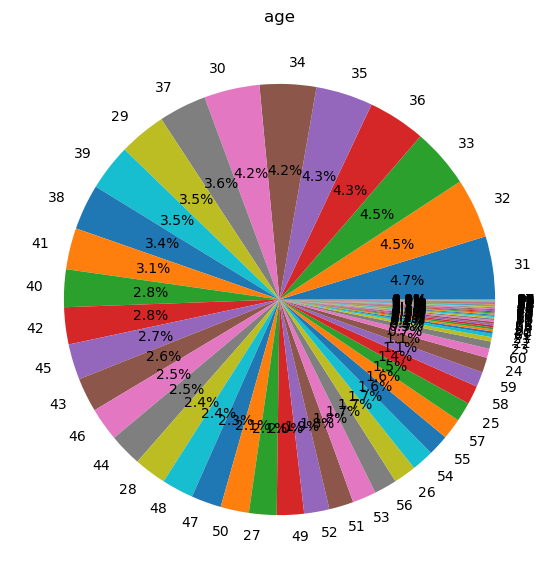

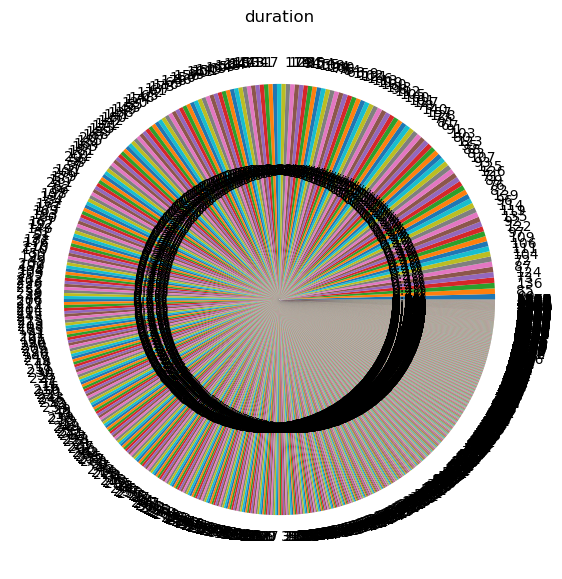

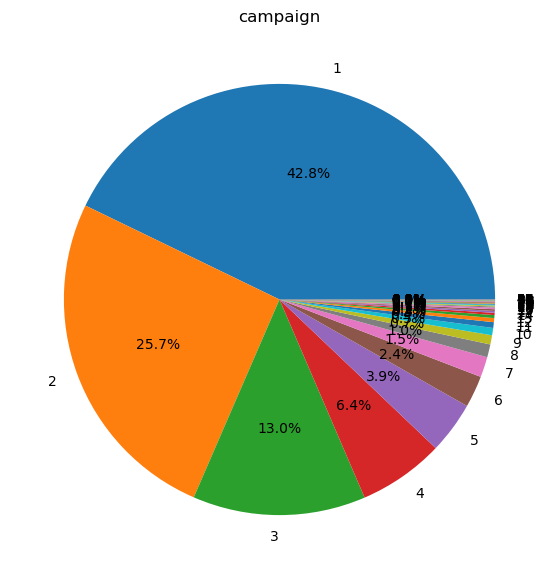

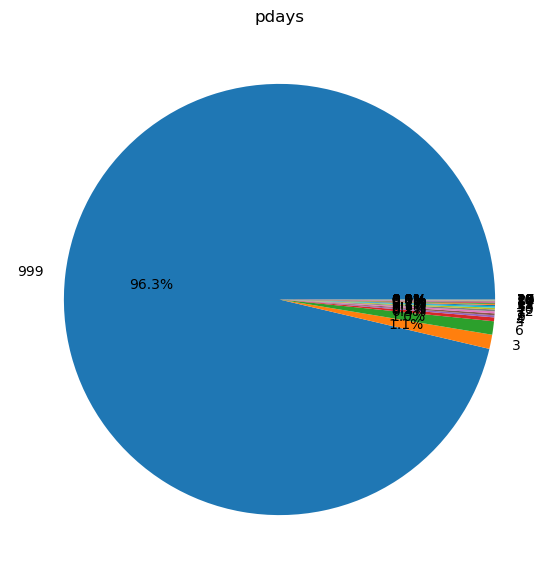

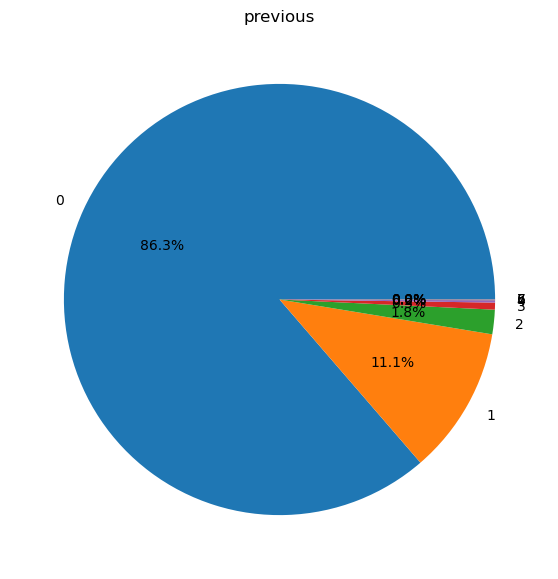

In [13]:
#numcolumns = ["age","campaign","pdays","previous","emp.var.rate","cons.price.idx","cons.conf.idx","euribor3m","nr.employed"]
#intcolumns = ["age","campaign","pdays","previous"]
#for col in intcolumns:
for col in bank_full_df.columns.tolist():
    match str(type(bank_full_df[col][0])):
        case "<class 'numpy.int64'>":
            pie_filling = bank_full_df.groupby([col])[col].count().sort_values(ascending=False)
            slice_of_pie = pd.DataFrame(pie_filling).rename(columns={col:col+"_count"})
            slice_of_pie.unstack(level=0).plot(
                kind="pie",
                stacked=False,
                subplots=False,
                autopct="%1.1f%%",
                figsize=(7, 7),labels = list(pie_filling.index.values)
                )
            plt.title(col)
            plt.show()
#        case "<class 'numpy.float64'>":
#            pie_filling = bank_full_df.groupby([col])[col].count().sort_values(ascending=False)
#            slice_of_pie = pd.DataFrame(pie_filling).rename(columns={col:col+"_count"})
#            slice_of_pie.unstack(level=0).plot(
#                kind="pie",
#                stacked=False,
#                subplots=False,
#                autopct="%1.1f%%",
#                figsize=(7, 7),labels = list(pie_filling.index.values)
#                )
#            plt.title(col)
#            plt.show()

##### Based on the diagrams generated, I think the folowing numeric features are important to the rest of this project
<ul><li>age</li></ul>

##### The other numeric features will not be used unless I change my mind later.

##### Let's draw histograms for the str features in the dataset.

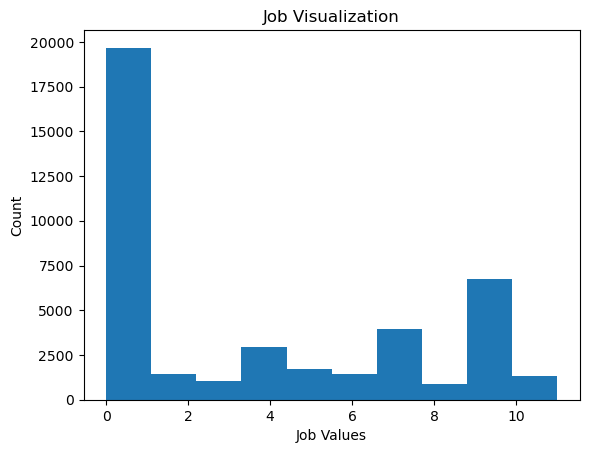

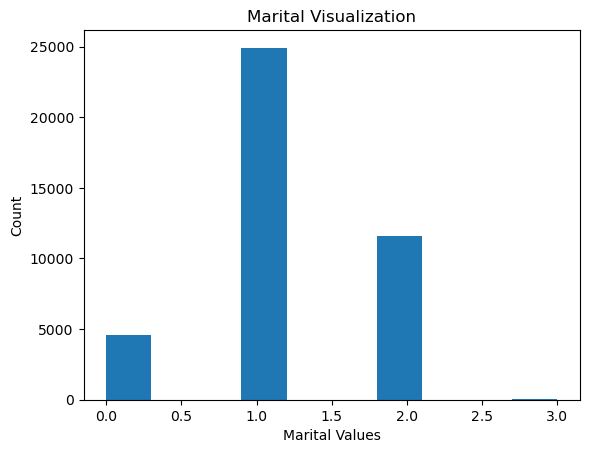

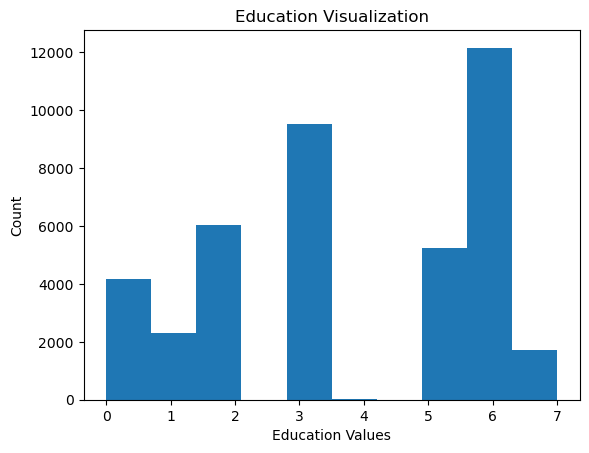

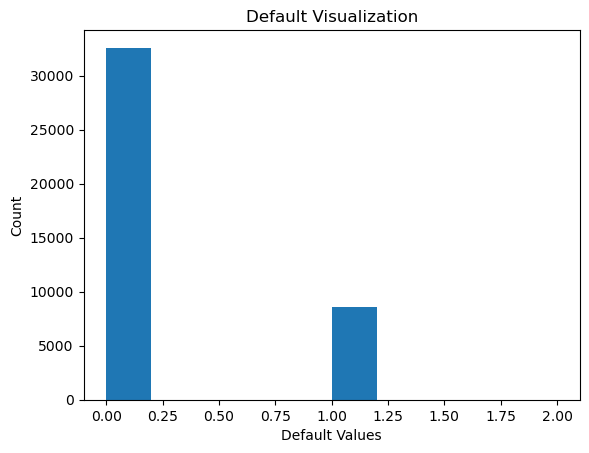

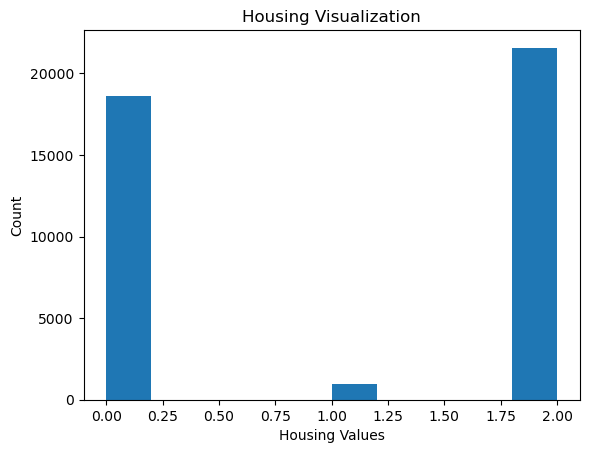

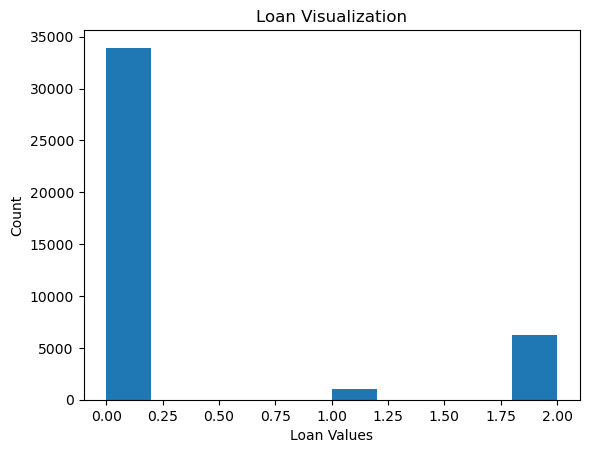

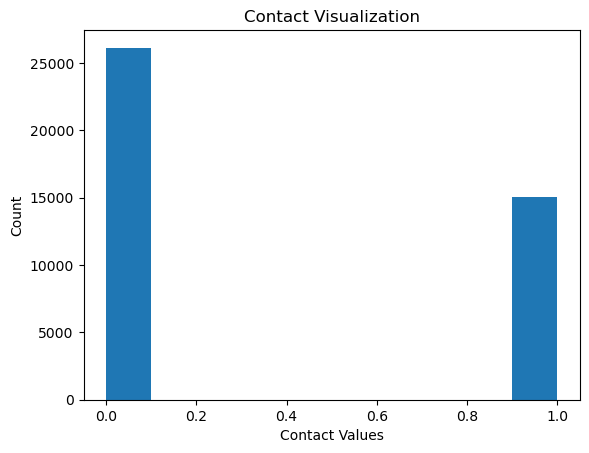

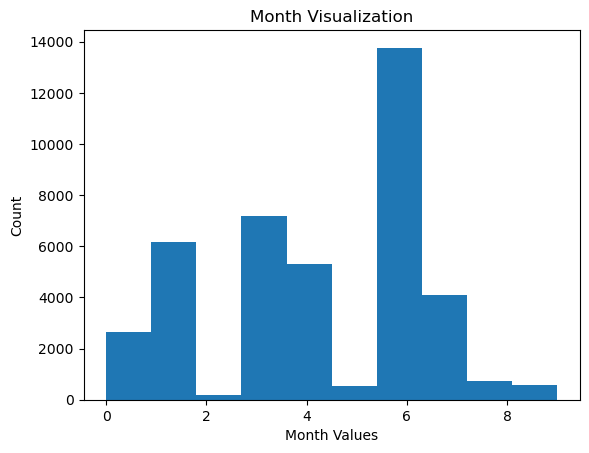

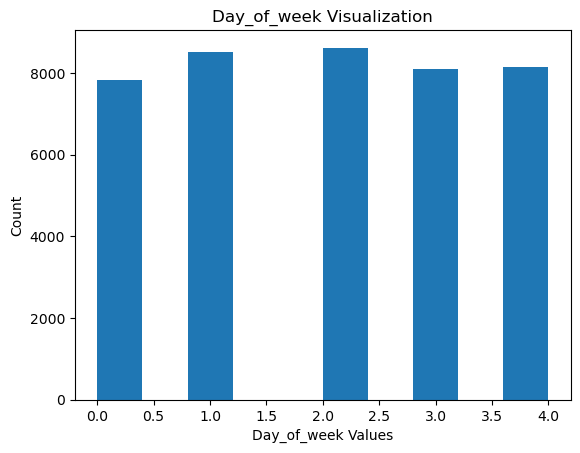

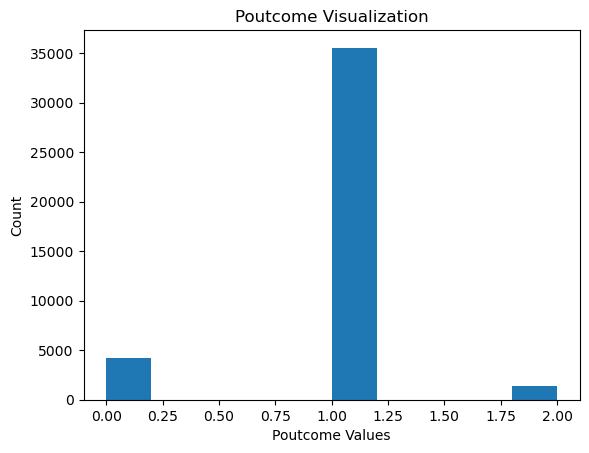

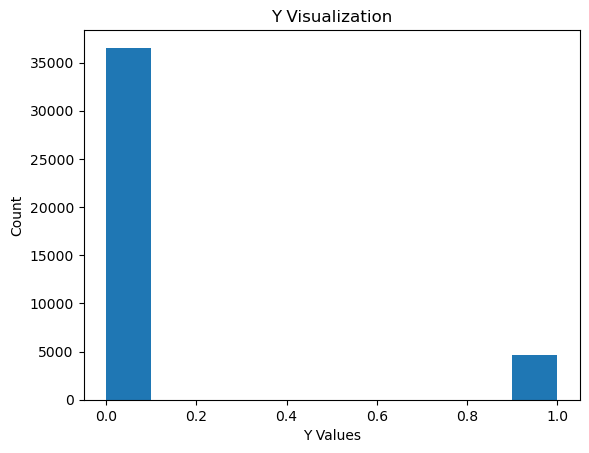

In [14]:
le_df = pd.DataFrame()

for col in bank_full_df.columns.tolist():
    match str(type(bank_full_df[col][0])):
        case "<class 'str'>":
            le_df[col] = le.fit_transform(bank_full_df[col])
            plt.hist(le_df[col])
            plt.title(col.capitalize() + ' Visualization')
            plt.xlabel(col.capitalize() + ' Values')
            plt.ylabel('Count')
            plt.show()

#le_df.head()

##### Let's do a group by for the str features

In [15]:
for col in bank_full_df.columns.tolist():
    match str(type(bank_full_df[col][0])):
        case "<class 'str'>":
            groupby_df = bank_full_df.groupby(["y",col]).agg({'y':['count']})
            print(groupby_df)
            print()

                      y
                  count
y   job                
no  admin.         9068
    blue-collar    8615
    entrepreneur   1332
    housemaid       954
    management     2596
    retired        1284
    self-employed  1272
    services       3644
    student         600
    technician     6009
    unemployed      870
    unknown         293
yes admin.         1351
    blue-collar     638
    entrepreneur    124
    housemaid       106
    management      328
    retired         434
    self-employed   149
    services        323
    student         275
    technician      730
    unemployed      144
    unknown          37

                  y
              count
y   marital        
no  divorced   4135
    married   22390
    single     9944
    unknown      68
yes divorced    476
    married    2531
    single     1620
    unknown      12

                             y
                         count
y   education                 
no  basic.4y              3748
    ba

##### Let's draw pie charts for the str features

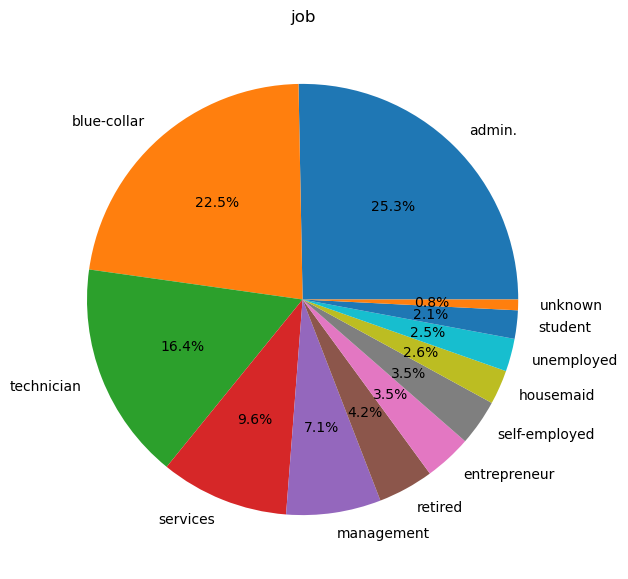

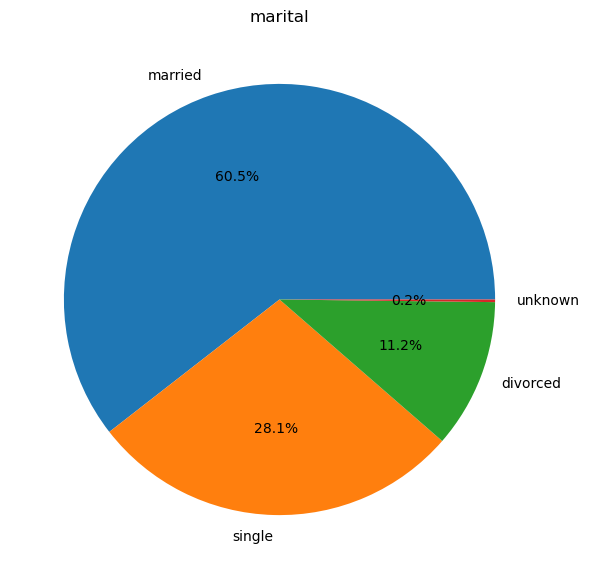

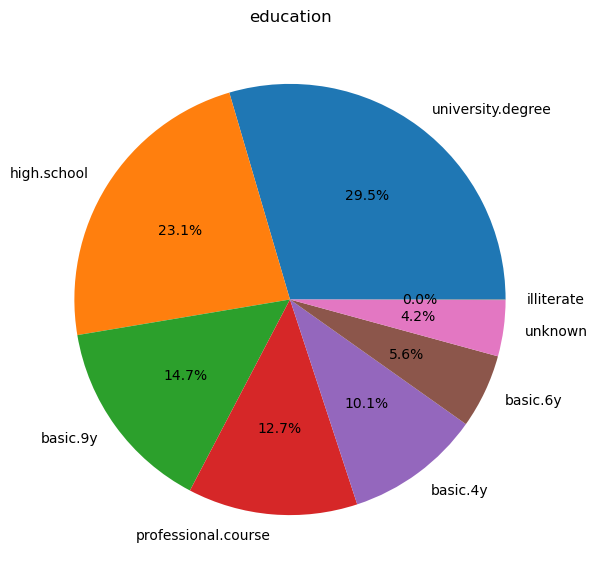

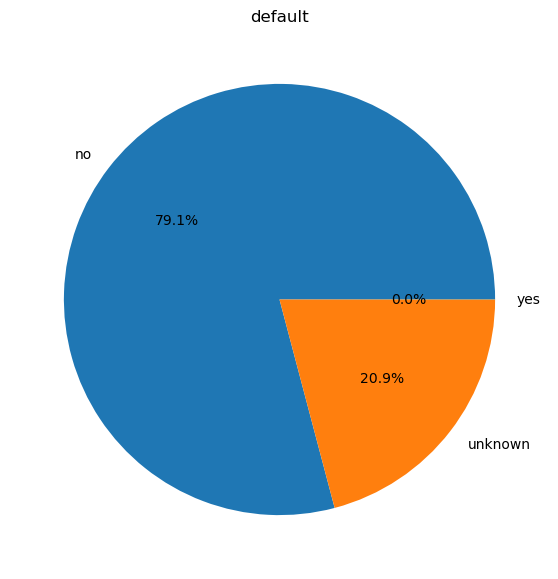

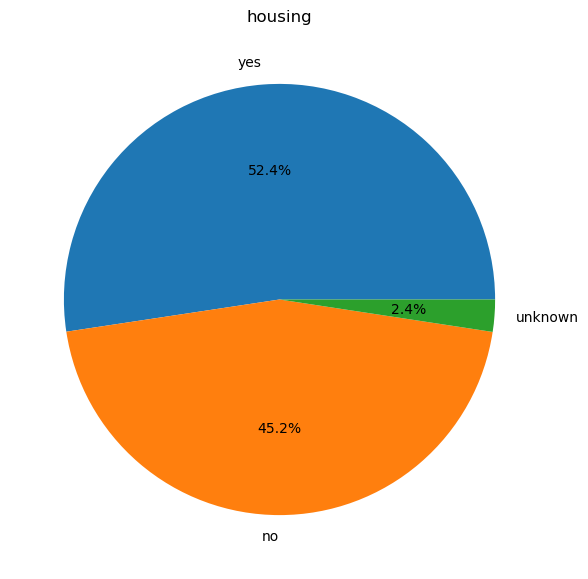

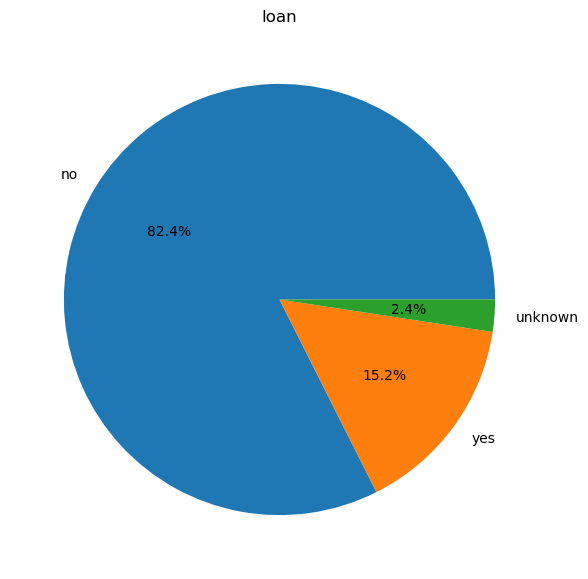

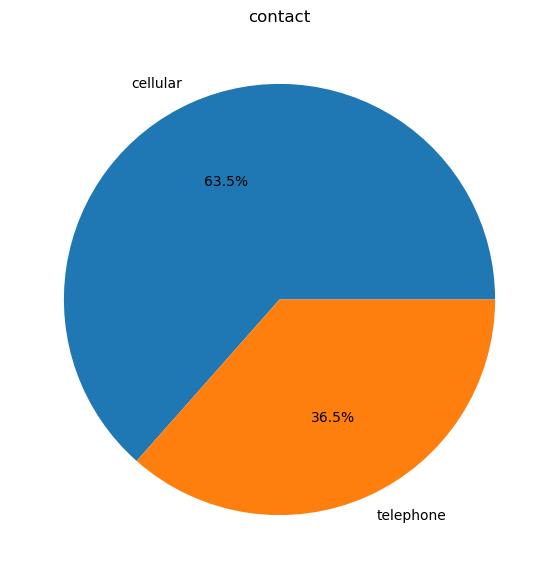

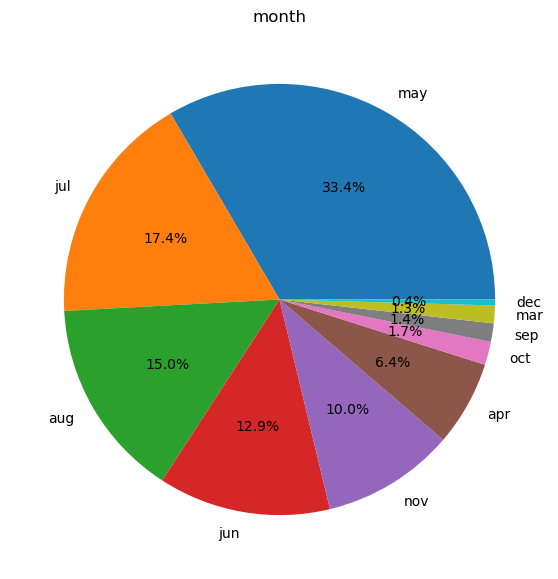

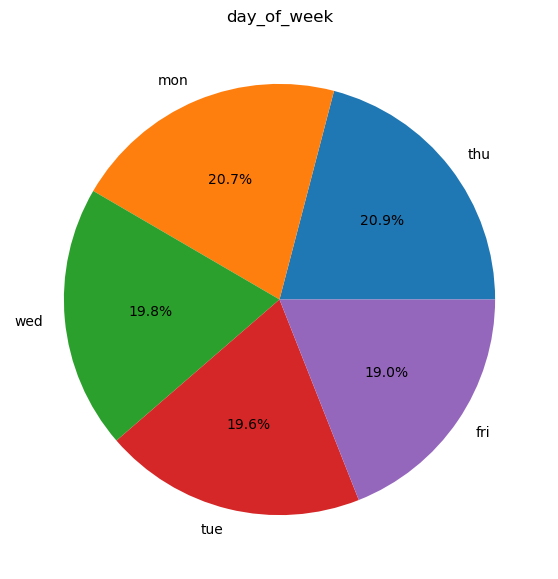

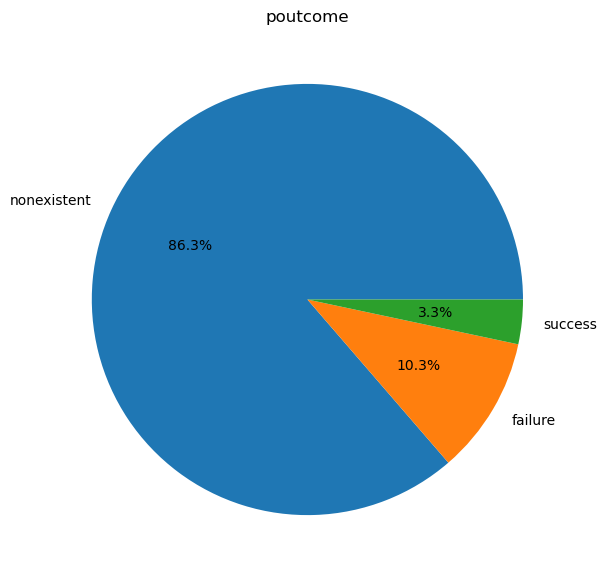

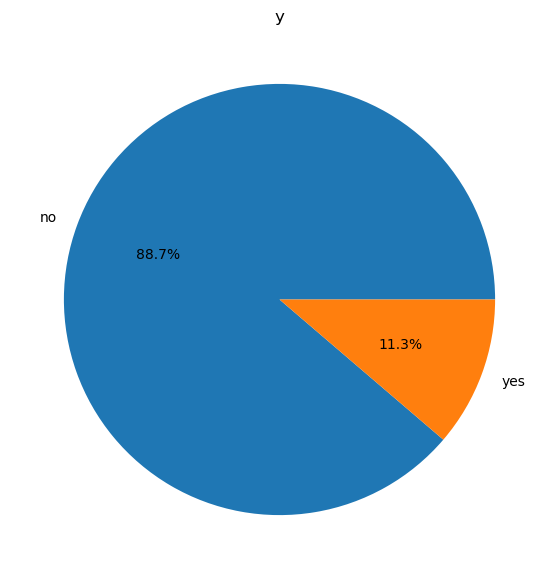

In [16]:
for col in bank_full_df.columns.tolist():
    match str(type(bank_full_df[col][0])):
        case "<class 'str'>":
            pie_filling = bank_full_df.groupby([col])[col].count().sort_values(ascending=False)
            slice_of_pie = pd.DataFrame(pie_filling).rename(columns={col:col+"_count"})
            slice_of_pie.unstack(level=0).plot(
                kind="pie",
                stacked=False,
                subplots=False,
                autopct="%1.1f%%",
                figsize=(7, 7),labels = list(pie_filling.index.values)
                )
            plt.title(col)
            plt.show()

##### Based on the diagrams generated, I think the folowing non-numeric features are important to the rest of this project
<ul><li>job</li><li>marital</li><li>education</li><li>default</li><li>housing</li><li>loan</li></ul>

##### A few might be eliminated based on Feature selection that will be performed next.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

##### Let's create a new dataframe with encoded features
<br/>
I previously selected 'age' from the list of int features and "default", "education", "marital", "job", "housing", "loan" from the list on str features
<br/>

##### Let's create a new feature for the encoded "y" feature

In [17]:
encoded_features_df = pd.DataFrame()
encoded_features_df["age"] = bank_full_df["age"]

#for col in bank_full_df.columns.tolist():
#    match str(type(bank_full_df[col][0])):
#        case "<class 'str'>":
for col in ["default", "education", "marital", "job", "housing", "loan"]:
    encoded_features_df[col] = le.fit_transform(bank_full_df[col])
encoded_features_df["client_subscribed"] = le.fit_transform(bank_full_df["y"])
encoded_features_df.tail()

,age,default,education,marital,job,housing,loan,client_subscribed
41171,73,0,5,1,5,2,0,1
41172,46,0,5,1,1,0,0,0
41173,56,0,6,1,5,2,0,0
41174,44,0,5,1,9,0,0,1
41175,74,0,5,1,5,2,0,0


##### Let's draw a heatmap with our selected features

<Axes: >

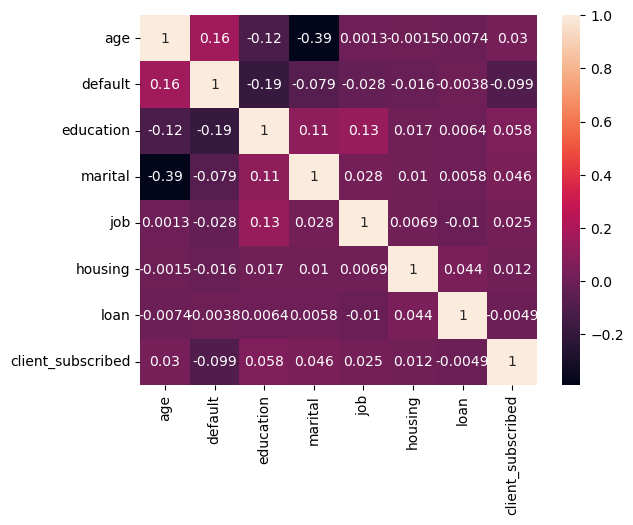

In [18]:
sns.heatmap(encoded_features_df.corr(),annot=True)

##### Let's create a correlation matrix with our selected features and sort it by the absolute value of the "client_subscribed" values

In [19]:
corr_matrix = encoded_features_df.corr()
sorted_corr_matrix = corr_matrix.sort_values(by="client_subscribed", key=abs, ascending=False)
sorted_corr_matrix

,age,default,education,marital,job,housing,loan,client_subscribed
client_subscribed,0.030381,-0.099364,0.057776,0.046249,0.025248,0.011613,-0.004922,1.000000
default,0.164939,1.000000,-0.186811,-0.079432,-0.028282,-0.015790,-0.003823,-0.099364
education,-0.117960,-0.186811,1.000000,0.109195,0.134159,0.016891,0.006441,0.057776
marital,-0.389829,-0.079432,0.109195,1.000000,0.027829,0.010499,0.005806,0.046249
age,1.000000,0.164939,-0.117960,-0.389829,0.001270,-0.001477,-0.007359,0.030381
job,0.001270,-0.028282,0.134159,0.027829,1.000000,0.006873,-0.010161,0.025248
housing,-0.001477,-0.015790,0.016891,0.010499,0.006873,1.000000,0.044272,0.011613
loan,-0.007359,-0.003823,0.006441,0.005806,-0.010161,0.044272,1.000000,-0.004922


##### Let's create and display a list of the features in order described above

In [20]:
features_list = list(sorted_corr_matrix.index)
features_list.pop(0)
features_list

['default', 'education', 'marital', 'age', 'job', 'housing', 'loan']

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

##### Let's create a random state variable once that we can use through out the Notebook

In [21]:
random_state_value = 42

##### Let's create X and y variables for the features selected

In [22]:
X = encoded_features_df[["age", "default", "education", "housing", "loan", "job", "marital"]]
y = encoded_features_df["client_subscribed"]

##### Let's split the prepared data into a train and test sets

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

##### Let's display the first 5 rows of the X dataframe

In [24]:
X.head()

,age,default,education,housing,loan,job,marital
0,56,0,0,0,0,3,1
1,57,1,3,0,0,7,1
2,37,0,3,2,0,7,1
3,40,0,1,0,0,0,1
4,56,0,3,0,2,7,1


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

##### Let's create a Dummy Classifier as the baseline and use GridSearchCV because it will provide valuable statistics we will neet later

In [25]:
baseline_clf = DummyClassifier()
baseline_params = {"strategy":["most_frequent"], "random_state":[random_state_value]}
baseline_gscv = GridSearchCV(baseline_clf, param_grid=baseline_params).fit(X, y)

##### Let's use the best estimator from GridSearchCV and make test and training predictions

In [26]:
baseline_clf_predict_test = baseline_gscv.best_estimator_.predict(X_test)
baseline_clf_predict_train = baseline_gscv.best_estimator_.predict(X_train)

##### Let's get MSE for test and training predictions as well as accuracy, best params, and mean fit time

In [27]:
baseline_test_mse = mean_squared_error(y_test, baseline_clf_predict_test)
baseline_train_mse = mean_squared_error(y_train, baseline_clf_predict_train)
baseline_test_acc = accuracy_score(y_test, baseline_clf_predict_test)
baseline_test_best = "{:.2f}%".format(baseline_gscv.best_score_ *100)

find_best_params = baseline_gscv.cv_results_["params"].index(baseline_gscv.best_params_)
baseline_mean_fit_time = baseline_gscv.cv_results_["mean_fit_time"][find_best_params]


##### Let's display statistics for our Baseline Model

In [28]:
print("Baseline Model")
for key in baseline_gscv.cv_results_.keys():
    print (key + " = " + str(baseline_gscv.cv_results_[key]))
print()
print ("Baseline Train MSE = " + str(baseline_train_mse))
print ("Baseline Test MSE = " + str(baseline_test_mse))
print ("Baseline Train Accuracy = " + str(baseline_test_acc))

Baseline Model
mean_fit_time = [0.]
std_fit_time = [0.]
mean_score_time = [0.00271373]
std_score_time = [0.00542746]
param_random_state = [42]
param_strategy = ['most_frequent']
params = [{'random_state': 42, 'strategy': 'most_frequent'}]
split0_test_score = [0.88732394]
split1_test_score = [0.88743169]
split2_test_score = [0.88731026]
split3_test_score = [0.88731026]
split4_test_score = [0.88731026]
mean_test_score = [0.88733728]
std_test_score = [4.75014213e-05]
rank_test_score = [1]

Baseline Train MSE = 0.11154286507303196
Baseline Test MSE = 0.11527564154456407
Baseline Train Accuracy = 0.884724358455436


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

##### Let's create a simple Logistic Regression model and use GridSearchCV for valuable statistics

In [29]:
lgr_clf = LogisticRegression()
lgr_params = {"random_state":[random_state_value]}
lgr_gscv = GridSearchCV(lgr_clf, param_grid=lgr_params).fit(X, y)

##### Let's use the best estimator from LogisticRegression and make test and training predictions
##### Let's get MSE for test and training predictions as well as accuracy, best params, and mean fit time
##### Let's get MSE for test and training predictions as well as accuracy, best params, and mean fit time
##### Let's display statistics for our Baseline Model

In [30]:
lgr_clf_predict_test = lgr_gscv.best_estimator_.predict(X_test)
lgr_clf_predict_train = lgr_gscv.best_estimator_.predict(X_train)

lgr_test_mse = mean_squared_error(y_test, lgr_clf_predict_test)
lgr_train_mse = mean_squared_error(y_train, lgr_clf_predict_train)
lgr_test_acc = accuracy_score(y_test, lgr_clf_predict_test)
lgr_test_best = "{:.2f}%".format(lgr_gscv.best_score_ *100)

print("LogisticRegression Model")
for key in lgr_gscv.cv_results_.keys():
    print (key + " = " + str(lgr_gscv.cv_results_[key]))
print()
print ("LogisticRegression Train MSE = " + str(lgr_train_mse))
print ("LogisticRegression Test MSE = " + str(lgr_test_mse))
print ("LogisticRegression Test Accuracy = " + str(lgr_test_acc))

LogisticRegression Model
mean_fit_time = [0.13828726]
std_fit_time = [0.01792985]
mean_score_time = [0.00312548]
std_score_time = [0.00625095]
param_random_state = [42]
params = [{'random_state': 42}]
split0_test_score = [0.88732394]
split1_test_score = [0.88743169]
split2_test_score = [0.88731026]
split3_test_score = [0.88731026]
split4_test_score = [0.88731026]
mean_test_score = [0.88733728]
std_test_score = [4.75014213e-05]
rank_test_score = [1]

LogisticRegression Train MSE = 0.11154286507303196
LogisticRegression Test MSE = 0.11527564154456407
LogisticRegression Test Accuracy = 0.884724358455436


### Problem 9: Score the Model

What is the accuracy of your model?

##### The accuracy score for LogisticRegression is 0.884724358455436

In [31]:
lgr_test_acc = "{:.2f}%".format(accuracy_score(y_test, lgr_clf_predict_test))
print ("LogisticRegression Test Accuracy = " + lgr_test_acc)

LogisticRegression Test Accuracy = 0.88%


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

##### Let's start coding KNN, Decision Tree, and SVM models

##### Let's keep KNN simple and then apply Hyperparameters in the next section

In [32]:
knn_clf = KNeighborsClassifier()
knn_params = {}
knn_gscv = GridSearchCV(knn_clf, param_grid=knn_params).fit(X, y)

In [33]:
knn_clf_predict_test = knn_gscv.best_estimator_.predict(X_test)
knn_clf_predict_train = knn_gscv.best_estimator_.predict(X_train)

knn_test_mse = mean_squared_error(y_test, knn_clf_predict_test)
knn_train_mse = mean_squared_error(y_train, knn_clf_predict_train)
knn_test_acc = accuracy_score(y_test, knn_clf_predict_test)
knn_test_best = "{:.2f}%".format(knn_gscv.best_score_ *100)

print("K Nearest Neighbor Model")
for key in knn_gscv.cv_results_.keys():
    print (key + " = " + str(knn_gscv.cv_results_[key]))
print()
print ("K Nearest Neighbor Train MSE = " + str(knn_train_mse))
print ("K Nearest Neighbor Train MSE Test MSE = " + str(knn_test_mse))
print ("K Nearest Neighbor Train MSE Test Accuracy = " + str(knn_test_acc))

K Nearest Neighbor Model
mean_fit_time = [0.04198399]
std_fit_time = [0.00575186]
mean_score_time = [0.14396935]
std_score_time = [0.00412317]
params = [{}]
split0_test_score = [0.88465274]
split1_test_score = [0.88136005]
split2_test_score = [0.88221008]
split3_test_score = [0.88136005]
split4_test_score = [0.84505161]
mean_test_score = [0.87492691]
std_test_score = [0.01498626]
rank_test_score = [1]

K Nearest Neighbor Train MSE = 0.10606113173507269
K Nearest Neighbor Train MSE Test MSE = 0.1082328179389622
K Nearest Neighbor Train MSE Test Accuracy = 0.8917671820610378


##### Let's keep Decision Tree simple and then apply Hyperparameters in the next section

In [34]:
dtree_clf = DecisionTreeClassifier()
dtree_params = {}
dtree_gscv = GridSearchCV(dtree_clf, param_grid=dtree_params).fit(X, y)

In [35]:
dtree_clf_predict_test = dtree_gscv.best_estimator_.predict(X_test)
dtree_clf_predict_train = dtree_gscv.best_estimator_.predict(X_train)

dtree_test_mse = mean_squared_error(y_test, dtree_clf_predict_test)
dtree_train_mse = mean_squared_error(y_train, dtree_clf_predict_train)
dtree_test_acc = accuracy_score(y_test, dtree_clf_predict_test)
dtree_test_best = "{:.2f}%".format(dtree_gscv.best_score_ *100)


print("Decision Tree Model")
for key in dtree_gscv.cv_results_.keys():
    print (key + " = " + str(dtree_gscv.cv_results_[key]))
print()
print ("Decision Tree Train MSE = " + str(dtree_train_mse))
print ("Decision Tree Train MSE Test MSE = " + str(dtree_test_mse))
print ("Decision Tree Train MSE Test Accuracy = " + str(dtree_test_acc))

Decision Tree Model
mean_fit_time = [0.05158515]
std_fit_time = [0.00621303]
mean_score_time = [0.00155153]
std_score_time = [0.00190665]
params = [{}]
split0_test_score = [0.8663186]
split1_test_score = [0.85913783]
split2_test_score = [0.84966606]
split3_test_score = [0.84820886]
split4_test_score = [0.81092896]
mean_test_score = [0.84685206]
std_test_score = [0.01913173]
rank_test_score = [1]

Decision Tree Train MSE = 0.08628525830066266
Decision Tree Train MSE Test MSE = 0.08653768315388974
Decision Tree Train MSE Test Accuracy = 0.9134623168461102


##### Let's try something different with SVM
##### Let's try a few kernels, but keep the rest of the options as default
##### Let's use cross validation to find the best kernel

In [ ]:
cv_scores = []
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for k in kernels:
    svc = SVC(kernel=k)
    scores = cross_val_score(svc, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_kernel = kernels[cv_scores.index(max(cv_scores))]
print(f"Optimal kernel is {optimal_kernel} with cross-validation score of {max(cv_scores)}")

##### Let's use the optimal kernel and a few basic params to get the best model

In [ ]:
params = {
    'C': [1],
    'gamma': [1],
    'kernel': [optimal_kernel],
    'decision_function_shape': ['ovo', 'ovr']
}

svc_gscv = GridSearchCV(SVC(), params, refit=True, verbose=2, cv=5).fit(X, y)
print(f"Best parameters found: {svc_gscv.best_params_}")

##### Let's use the optimal kernel and parms to get a baseline for SVM

In [ ]:
svc_clf_predict_test = svc_gscv.best_estimator_.predict(X_test)
svc_clf_predict_train = svc_gscv.best_estimator_.predict(X_train)

svc_test_mse = mean_squared_error(y_test, svc_clf_predict_test)
svc_train_mse = mean_squared_error(y_train, svc_clf_predict_train)
svc_test_acc = accuracy_score(y_test, svc_clf_predict_test)
svc_test_best = "{:.2f}%".format(svc_gscv.best_score_ *100)

print("Support Vector Machine Model")
for key in svc_gscv.cv_results_.keys():
    print (key + " = " + str(svc_gscv.cv_results_[key]))
print()
print ("Support Vector Machine Train MSE = " + str(svc_train_mse))
print ("Support Vector Machine Train MSE Test MSE = " + str(svc_test_mse))
print ("Support Vector Machine Train MSE Test Accuracy = " + str(svc_test_acc))

##### Let's create an object with all of the statistics that we created so far

In [ ]:
results_dict = {"model":[],"accuracy score":[],"best score":[],"train score":[],"test score":[],"mean fit time":[]}

In [ ]:

results_dict['model'].append('Baseline b')
results_dict['model'].append('Logistic Regression b')
results_dict['model'].append('KNN b')
results_dict['model'].append('Decision Tree b')
results_dict['model'].append('SVC b')

results_dict['accuracy score'].append(baseline_test_acc)
results_dict['accuracy score'].append(lgr_test_acc)
results_dict['accuracy score'].append(knn_test_acc)
results_dict['accuracy score'].append(dtree_test_acc)
results_dict['accuracy score'].append(svc_test_acc)

results_dict['best score'].append(baseline_test_best)
results_dict['best score'].append(lgr_test_best)
results_dict['best score'].append(knn_test_best)
results_dict['best score'].append(dtree_test_best)
results_dict['best score'].append(svc_test_best)

results_dict['train score'].append(baseline_train_mse)
results_dict['train score'].append(lgr_train_mse)
results_dict['train score'].append(knn_train_mse)
results_dict['train score'].append(dtree_train_mse)
results_dict['train score'].append(svc_train_mse)

results_dict['test score'].append(baseline_test_mse)
results_dict['test score'].append(lgr_test_mse)
results_dict['test score'].append(knn_test_mse)
results_dict['test score'].append(dtree_test_mse)
results_dict['test score'].append(svc_test_mse)

results_dict['mean fit time'].append(baseline_gscv.cv_results_['mean_fit_time'][0])
results_dict['mean fit time'].append(lgr_gscv.cv_results_['mean_fit_time'][0])
results_dict['mean fit time'].append(knn_gscv.cv_results_['mean_fit_time'][0])
results_dict['mean fit time'].append(dtree_gscv.cv_results_['mean_fit_time'][0])
results_dict['mean fit time'].append(svc_gscv.cv_results_['mean_fit_time'][0])

results_dict

##### Let's create a dataframe with the data collected and display them

In [ ]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### Let's use zscore to find outliers in the "age" feature, zscore greater than 3 will be our determining value

In [ ]:
encoded_features_df['z_age'] = np.abs(stats.zscore(X['age']))
zage = list(np.where(np.abs(encoded_features_df['z_age']) > 3)[0])
print("Age Outliers: ", zage)
print("Total outlier Age: ", len(zage), "\n")

##### WOW!  369 records can be elminated.
##### Let's display the dataset.

In [ ]:
encoded_features_df.head()

##### Let's drop the records that meet our zscore requirement
##### Let's drop the feature we created for zscore
##### Let's disply information about a DataFrame including the index dtype and columns, non-null values and memory usage

In [ ]:
encoded_features_df.drop(encoded_features_df.index[zage], inplace=True)
encoded_features_df.drop(columns=['z_age'], inplace=True)
encoded_features_df.info()

##### Let's draw a histogram for the Age feature

In [ ]:
plt.hist(encoded_features_df['age'])
plt.title('Age Visualization')
plt.xlabel('Age Values')
plt.ylabel('Count')
plt.show()

##### That looks better than before!  The data looks more distributed.  I think we can skip normalizing this feature

##### Let's draw some bar charts for our selected features

In [ ]:
for col in ['age', 'default', 'education', 'housing', 'loan', 'marital', 'job']:
    fig = px.box(bank_full_df, y=encoded_features_df[col], x=encoded_features_df["client_subscribed"],title=col.capitalize() + ' Visualization')
    fig.show()

##### These look good!  Let's continue with this and come back if we encounter any issues later.

##### Let's create X and y variables for the features selected

In [ ]:
X = encoded_features_df[["age", "default", "education", "housing", "loan", "job", "marital"]]
y = encoded_features_df["client_subscribed"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

##### Let's create a num_features_to_select variable once that we can use through out the Notebook

In [ ]:
num_features_to_select=5

##### Let's create a Logistic Regression model and ask RFE to select features for us

In [ ]:
lgr_clf = LogisticRegression()
selector = RFE(lgr_clf, n_features_to_select=num_features_to_select)
selector.fit(X, y)
selected_features = selector.get_support()
print('The selected features are:', list(X.columns[selected_features]))

##### Let's create a Logistic Regression model and ask SequentialFeatureSelector to select features for us

In [ ]:
lgr_clf = LogisticRegression()
selector = SequentialFeatureSelector(lgr_clf, n_features_to_select=num_features_to_select)
selector.fit(X, y)
selected_features = selector.get_support()
print('The selected features are:', list(X.columns[selected_features]))

##### Let's create a KNeighborsClassifier model and ask SequentialFeatureSelector to select features for us

In [ ]:
knn_clf = KNeighborsClassifier()
selector = SequentialFeatureSelector(knn_clf, n_features_to_select=num_features_to_select)
selector.fit(X, y)
selected_features = selector.get_support()
print('The selected features are:', list(X.columns[selected_features]))

##### Let's create a DecisionTreeClassifier model and ask RFE to select features for us

In [ ]:
dtree_clf = DecisionTreeClassifier()
selector = RFE(dtree_clf, n_features_to_select=num_features_to_select)
selector.fit(X, y)
selected_features = selector.get_support()
print('The selected features are:', list(X.columns[selected_features]))

##### Let's create a DecisionTreeClassifier model and ask SequentialFeatureSelector to select features for us

In [ ]:
dtree_clf = DecisionTreeClassifier()
selector = SequentialFeatureSelector(dtree_clf, n_features_to_select=num_features_to_select)
selector.fit(X, y)
selected_features = selector.get_support()
print('The selected features are:', list(X.columns[selected_features]))

##### Let's create a SVC model and ask RFE to select features for us

In [ ]:
svc_clf = SVC(**svc_gscv.best_params_)
selector = RFE(svc_clf, n_features_to_select=num_features_to_select, step=1)
selector.fit(X, y)
selected_features = selector.get_support()
print('The selected features are:', list(X.columns[selected_features]))

##### Here's  a breakdown
<ul>
    <li>features selected</li>
    <li>how many times each was selected</li>
    <li>% from the pie charts for tie breaking</li>
</ul>
<br/>
age , count 3<br/>
default , count 5, no 79.1% , unknown 20.9% , yes 0%<br/>
education , count 5<br/>
loan , count 5 , no 82.4% , yes 15.2% , unknown 2.4%<br/>
marital , count 6<br/>
housing , count 6 , yes 52.4% , no 45.2% , unknown 2.4%<br/>
<br/>
    
##### List of selected features
    
['default', 'education', 'housing', 'loan', 'marital']<br/>
['age', 'default', 'education', 'housing', 'loan']<br/>
['default', 'education', 'housing', 'loan', 'marital']<br/>
<b>['age', 'education', 'housing', 'job', 'marital']</b><br/>
['default', 'education', 'housing', 'loan', 'marital']<br/>
['age', 'default', 'housing', 'loan', 'marital']<br/>

##### Let's create X and y variables for the features selected

In [ ]:
X = encoded_features_df[['age', 'education', 'housing', 'job', 'marital']]
y = encoded_features_df["client_subscribed"]

##### Let's split the prepared data into a train and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

##### Let's create a function to display the stastics that we are going to start collecting.

In [ ]:
def print_stuff(title, gscv, train_mse, test_mse, test_acc, clf_score, fit_time, cv_scores):
    print(title + " Model")
    print()
    for key in gscv.cv_results_.keys():
        print (key + " = " + str(gscv.cv_results_[key]))
    print()
    print("Best Params")
    print(gscv.best_params_)
    print()
    print("Best Mean Fit Time = " + str(fit_time))
    print()
    print("Accuracy with tuning is : {:.2f}%".format(gscv.best_score_ *100) )
    print()
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Average CV Score: {cv_scores.mean()}")
    print()
    print (title + " Train MSE = " + str(train_mse))
    print (title + " MSE = " + str(test_mse))
    print (title + " Accuracy = " + str(test_acc))
    print (title + " Score = " + str(clf_score))
    print()

##### Let's create a classification_targets variable once that we can use through out the Notebook

In [ ]:
classification_targets = ["Client did not Subscribe","Client Subscribed"]

##### Let's create a Logistic Regression model and try a hyper parameter with Grid Search CV

In [ ]:
lgr_clf = LogisticRegression()
lgr_params = {"random_state":[random_state_value],"C":[0.001, 0.002, 0.003]}
lgr_gscv = GridSearchCV(lgr_clf, param_grid=lgr_params, scoring='roc_auc').fit(X, y)

##### Let's gather & display some results along with a Classification Report

In [ ]:
lgr_clf_predict_test = lgr_gscv.best_estimator_.predict(X_test)
lgr_clf_predict_train = lgr_gscv.best_estimator_.predict(X_train)
lgr_clf_score = lgr_gscv.score(X,y)

lgr_test_mse = mean_squared_error(y_test, lgr_clf_predict_test)
lgr_train_mse = mean_squared_error(y_train, lgr_clf_predict_train)
lgr_test_acc = accuracy_score(y_test, lgr_clf_predict_test)
lgr_test_best = "{:.2f}%".format(lgr_gscv.best_score_ *100)

find_best_params = lgr_gscv.cv_results_["params"].index(lgr_gscv.best_params_)
lgr_mean_fit_time = lgr_gscv.cv_results_["mean_fit_time"][find_best_params]

lgr_cv_scores = cross_val_score(lgr_gscv.best_estimator_, X_train, y_train, cv=5)

print_stuff("LogisticRegression", lgr_gscv, lgr_train_mse, lgr_test_mse, lgr_test_acc, lgr_clf_score, lgr_mean_fit_time, lgr_cv_scores)
print("Classification Report:\n", classification_report(y_test, lgr_clf_predict_test, target_names=classification_targets))

##### Grid Search CV return Best Params = {'C': 0.001, 'random_state': 42}

##### Let's create a KNeighborsClassifier model and try a hyper parameter with Grid Search CV

In [ ]:
knn_clf = KNeighborsClassifier()
knn_params = {"n_neighbors":[13,14,15]}
knn_gscv = GridSearchCV(knn_clf, param_grid=knn_params, scoring='roc_auc').fit(X, y)

##### Let's gather & display some results along with a Classification Report

In [ ]:
knn_clf_predict_test = knn_gscv.best_estimator_.predict(X_test)
knn_clf_predict_train = knn_gscv.best_estimator_.predict(X_train)
knn_clf_score = knn_gscv.score(X,y)

knn_test_mse = mean_squared_error(y_test, knn_clf_predict_test)
knn_train_mse = mean_squared_error(y_train, knn_clf_predict_train)
knn_test_acc = accuracy_score(y_test, knn_clf_predict_test)
knn_test_best = "{:.2f}%".format(knn_gscv.best_score_ *100)

find_best_params = knn_gscv.cv_results_["params"].index(knn_gscv.best_params_)
knn_mean_fit_time = knn_gscv.cv_results_["mean_fit_time"][find_best_params]

knn_cv_scores = cross_val_score(knn_gscv.best_estimator_, X_train, y_train, cv=5)

print_stuff("K Nearest Neighbor", knn_gscv, knn_train_mse, knn_test_mse, knn_test_acc, knn_clf_score, knn_mean_fit_time, knn_cv_scores)
print("Classification Report:\n", classification_report(y_test, knn_clf_predict_test, target_names=classification_targets))

##### Grid Search CV return Best Params = {'n_neighbors': 14}

##### Let's create a Decision Tree model and try a hyper parameter with Grid Search CV

In [ ]:
dtree_clf = DecisionTreeClassifier()
dtree_params = {
    "criterion": ["entropy","gini"],
    "max_depth": [2,3,4],
    "random_state":[random_state_value]}
dtree_gscv = GridSearchCV(dtree_clf, param_grid=dtree_params, scoring='roc_auc').fit(X, y)

##### Let's gather & display some results along with a Classification Report

In [ ]:
dtree_clf_predict_test = dtree_gscv.best_estimator_.predict(X_test)
dtree_clf_predict_train = dtree_gscv.best_estimator_.predict(X_train)
dtree_clf_score = dtree_gscv.score(X,y)

dtree_test_mse = mean_squared_error(y_test, dtree_clf_predict_test)
dtree_train_mse = mean_squared_error(y_train, dtree_clf_predict_train)
dtree_test_acc = accuracy_score(y_test, dtree_clf_predict_test)
dtree_test_best = "{:.2f}%".format(dtree_gscv.best_score_ *100)

find_best_params = dtree_gscv.cv_results_["params"].index(dtree_gscv.best_params_)
dtree_mean_fit_time = dtree_gscv.cv_results_["mean_fit_time"][find_best_params]

dtree_cv_scores = cross_val_score(dtree_gscv.best_estimator_, X_train, y_train, cv=5)

print_stuff("Decision Tree", dtree_gscv, dtree_train_mse, dtree_test_mse, dtree_test_acc, dtree_clf_score, dtree_mean_fit_time, dtree_cv_scores )
print("Classification Report:\n", classification_report(y_test, dtree_clf_predict_test, target_names=classification_targets))

##### Grid Search CV return Best Params = {'criterion': 'entropy', 'max_depth': 3, 'random_state': 42}

##### Let's try something different with SVM
##### Let's try a few kernels, but keep the rest of the options as default
##### Let's use cross validation to find the best kernel

In [ ]:
cv_scores = []
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for k in kernels:
    svc = SVC(kernel=k)
    scores = cross_val_score(svc, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_kernel = kernels[cv_scores.index(max(cv_scores))]
print(f"Optimal kernel is {optimal_kernel} with cross-validation score of {max(cv_scores)}")

##### Let's use the optimal kernel and a few basic params to get the best model

In [ ]:
params = {
    'C': [1],
    'gamma': [1],
    'kernel': [optimal_kernel],
    'decision_function_shape': ['ovo', 'ovr']
}

svc_gscv = GridSearchCV(SVC(), params, refit=True, verbose=2, cv=5, scoring='roc_auc').fit(X, y)
print(f"Best parameters found: {svc_gscv.best_params_}")

##### Grid Search CV return Best Params = {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'linear'}

##### Let's gather & display some results along with a Classification Report

In [ ]:
svc_clf_predict_test = svc_gscv.best_estimator_.predict(X_test)
svc_clf_predict_train = svc_gscv.best_estimator_.predict(X_train)
svc_clf_score = svc_gscv.score(X,y)

svc_test_mse = mean_squared_error(y_test, svc_clf_predict_test)
svc_train_mse = mean_squared_error(y_train, svc_clf_predict_train)
svc_test_acc = accuracy_score(y_test, svc_clf_predict_test)
svc_test_best = "{:.2f}%".format(svc_gscv.best_score_ *100)

find_best_params = svc_gscv.cv_results_["params"].index(svc_gscv.best_params_)
svc_mean_fit_time = svc_gscv.cv_results_["mean_fit_time"][find_best_params]

svc_cv_scores = cross_val_score(svc_gscv.best_estimator_, X_train, y_train, cv=5)

print_stuff("Support Vector Machine", svc_gscv, svc_train_mse, svc_test_mse, svc_test_acc, svc_clf_score, svc_mean_fit_time, svc_cv_scores)
print("Classification Report:\n", classification_report(y_test, svc_clf_predict_test, target_names=classification_targets))

##### Let's append the results object with the new statistics that we created

In [ ]:

results_dict['model'].append('Logistic Regression 1')
results_dict['model'].append('KNN 1')
results_dict['model'].append('Decision Tree 1')
results_dict['model'].append('SVC 1')

results_dict['accuracy score'].append(lgr_test_acc)
results_dict['accuracy score'].append(knn_test_acc)
results_dict['accuracy score'].append(dtree_test_acc)
results_dict['accuracy score'].append(svc_test_acc)

results_dict['best score'].append(lgr_test_best)
results_dict['best score'].append(knn_test_best)
results_dict['best score'].append(dtree_test_best)
results_dict['best score'].append(svc_test_best)

results_dict['train score'].append(lgr_train_mse)
results_dict['train score'].append(knn_train_mse)
results_dict['train score'].append(dtree_train_mse)
results_dict['train score'].append(svc_train_mse)

results_dict['test score'].append(lgr_test_mse)
results_dict['test score'].append(knn_test_mse)
results_dict['test score'].append(dtree_test_mse)
results_dict['test score'].append(svc_test_mse)

results_dict['mean fit time'].append(lgr_gscv.cv_results_['mean_fit_time'][0])
results_dict['mean fit time'].append(knn_gscv.cv_results_['mean_fit_time'][0])
results_dict['mean fit time'].append(dtree_gscv.cv_results_['mean_fit_time'][0])
results_dict['mean fit time'].append(svc_gscv.cv_results_['mean_fit_time'][0])

results_dict

##### Let's create a dataframe with the data collected and display them

In [ ]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

##### Questions